In [14]:
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns

In [15]:
import h5py
import numpy as np
from astropy.units import deg
#from lenstools import GaussianNoiseGenerator, ConvergenceMap
from scipy.ndimage import gaussian_filter

I want to study the global property of the clone dsets that I made. Specifically, 
* Power spectra
* Peak counts
* General pixel counts

I also want to see if these have any trends with cosmology, esp compared to the original maps. 

In [16]:
smooth = 0.0
shape_noise= 0.0
data_mod = lambda x: gaussian_filter(x+np.random.randn(*x.shape)*shape_noise, smooth)# add a normalization, hopefully sufficient

In [17]:
def image_ps(image):
    l = np.linspace(128, 128**2, 180)
    cmap = ConvergenceMap(image, angle=10*deg)
    _, psd1D = cmap.powerSpectrum(l)

    return psd1D#/psd1D[0]

In [18]:
def image_bs(image):
    l = np.linspace(128, 128**2, 180)
    cmap = ConvergenceMap(image, angle=10*deg)
    _, psd1D = cmap.bispectrum(l)

    return psd1D#/psd1D[0]

In [19]:
def image_pc(image):
    #image = (image-image.mean())/image.std()
    cmap = ConvergenceMap(image, angle=10*deg)
    thresholds = np.linspace(-0.1, 0.2 ,200)
    #thresholds = np.linspace(-5, 5, 200)
    nu,peaks = cmap.peakCount(thresholds, norm=False)
    return peaks#/psd1D[0]

In [20]:
def image_pdf(image):
    image = (image-image.mean())/image.std()
    cmap = ConvergenceMap(image, angle=10*deg)
    #thresholds = np.arange(0.1, 0.3 ,0.001)
    thresholds = np.linspace(-5, 5, 200)
    _,pdf = cmap.pdf(thresholds, norm=True)
    return pdf#/psd1D[0]

In [21]:
orig_fname = '/home/users/swmclau2/oak/Uatu/UatuFastPMTraining/UatuFastPMTraining.hdf5'
grf_fname = '/home/users/swmclau2/oak/Uatu/UatuFastPMTraining/UatuFastPMTrainingGRF_smooth_%0.1f_noise_%0.1f.hdf5'%(smooth,shape_noise)
clone_fname = '/scratch/users/swmclau2/clone_maps/UatuFastPMTrainingRobustifyDeepResnetRegAdvWhiteNoise%0.1f_v6.hdf5'%smooth
#clone_fname2 = '/scratch/users/swmclau2/clone_maps/UatuFastPMTrainingRobustifyDeepResnetRegAdvWhiteNoise%0.1f_v4.hdf5'%smooth

#clone_fname = '/home/users/swmclau2/oak/Uatu/UatuFastPMTraining/UatuFastPMTrainingRobustifyDeepResnetRegAdvGRFNoise1.0.hdf5'

In [24]:
def plot_set(orig_fname, grf_fname, clone_fname, boxno, idx):
    fig = plt.figure(figsize=(18,6))
    with h5py.File(orig_fname, 'r') as f:
        mean, std = f.attrs['mean'], f.attrs['std']
        X1 = f[boxno]['X'][idx, :].squeeze()
        X1 = data_mod(X1)
        X1 = (X1-X1.mean())/X1.std()
        
        
    with h5py.File(grf_fname, 'r') as f:
        #mean, std = f.attrs['mean'], f.attrs['std']
        #X2 = f[boxno]['X'][idx, :].squeeze()
        #X2 = (X2-X2.mean())/X2.std()
        pass
    X2 = np.random.randn(*X1.shape)
        
    with h5py.File(clone_fname, 'r') as f:
        #mean, std = f.attrs['mean'], f.attrs['std']
        X3 = f[boxno]['X'][idx, :].squeeze()
        #X3 = (X3-X3.mean())/X3.std()

    plt.subplot(131)
    plt.title('Original')
    im = plt.imshow(X1)
    plt.subplot(132)
    plt.title('White Noise')
    im = plt.imshow(X2)#, vmin=-0.03, vmax=0.03)
    plt.subplot(133)
    plt.title('Clone')
    im = plt.imshow(X3)#,vmin=-0.03, vmax=0.03)
    #plt.colorbar(im)
    plt.show()
    print X1.min(), X1.max(), X1.mean(), X1.std()
    print X2.min(), X2.max(), X2.mean(), X2.std()
    print X3.min(), X3.max(), X3.mean(), X3.std()

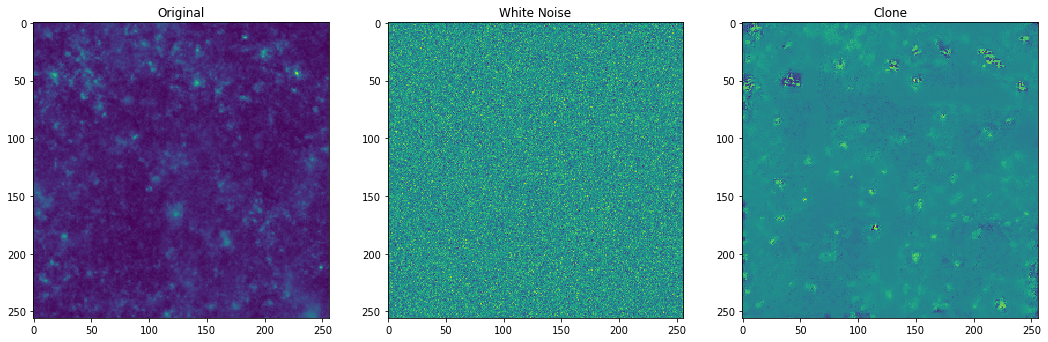

-1.78045956464 14.9276546004 1.04083408559e-17 1.0
-4.42692155883 4.17205085815 0.0019241683633 0.998137767861
-0.0345841 0.0407449 0.00052729 0.00396016


In [25]:
xt = plot_set(orig_fname, grf_fname, clone_fname, 'Box000', 0)

In [11]:
def plot_fft(orig_fname, grf_fname, clone_fname, boxno, idx):
    fig = plt.figure(figsize=(18,6))
    with h5py.File(orig_fname, 'r') as f:
        mean, std = f.attrs['mean'], f.attrs['std']
        X1 = f[boxno]['X'][idx, :].squeeze()
        X1 = data_mod(X1)
        X1 = (X1-X1.mean())/X1.std()
        
        
    with h5py.File(grf_fname, 'r') as f:
        #mean, std = f.attrs['mean'], f.attrs['std']
        #X2 = f[boxno]['X'][idx, :].squeeze()
        #X2 = (X2-X2.mean())/X2.std()
        pass
    X2 = np.random.randn(*X1.shape)
        
    with h5py.File(clone_fname, 'r') as f:
        #mean, std = f.attrs['mean'], f.attrs['std']
        X3 = f[boxno]['X'][idx, :].squeeze()
        X3 = (X3-X3.mean())/X3.std()

    plt.subplot(131)
    plt.title('Original')
    im = plt.imshow(np.log(np.abs(np.fft.fftn(X1)**2)))
    plt.subplot(132)
    plt.title('White Noise')
    im = plt.imshow(np.log(np.abs(np.fft.fftn(X2)**2)))#, vmin=-0.03, vmax=0.03)
    plt.subplot(133)
    plt.title('Clone')
    im = plt.imshow(np.log(np.abs(np.fft.fftn(X3)**2)))#,vmin=-0.03, vmax=0.03)
    #plt.colorbar(im)
    plt.show()
    print X1.min(), X1.max(), X1.mean(), X1.std()
    print X2.min(), X2.max(), X2.mean(), X2.std()
    print X3.min(), X3.max(), X3.mean(), X3.std()

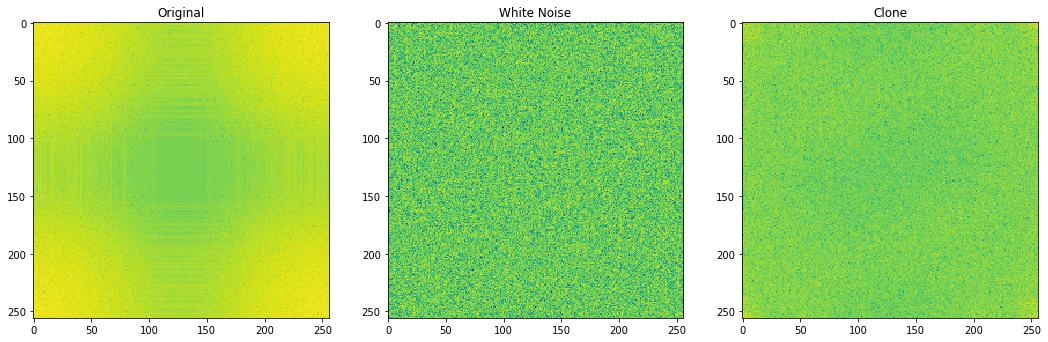

-4.65965273096 4.28119060439 2.08166817117e-17 1.0
-4.58290685142 4.9998608464 0.010613955027 1.00319069105
-5.94629 6.70939 2.32831e-08 1.0


In [12]:
xt = plot_fft(orig_fname, grf_fname, clone_fname, 'Box064', 452)

In [38]:
def compute_all_ps(fname, boxno, normalize= False, mod=False):
    with h5py.File(fname, 'r') as f:
        X = f[boxno]['X'][()].squeeze()#, f[boxno]['Y'][0,:]
        if mod:
            X = data_mod(X)
        if normalize:
            mean, std = f.attrs['mean'], f.attrs['std']
            o_mean, o_std = X.mean(), X.std()
            #print(mean, std)
            #print(X.mean(), X.std())
            X = ((X-o_mean)/o_std)*std+mean
            
        all_ps = np.zeros((36**2, 179))
        for i, x in enumerate(X):
            all_ps[i] = image_ps(x)
            
    return all_ps

In [39]:
def compute_all_bs(fname, boxno, normalize= True, mod=False):
    with h5py.File(fname, 'r') as f:
        X = f[boxno]['X'][()].squeeze()#, f[boxno]['Y'][0,:]
        if mod:
            X = data_mod(X)
        if normalize:
            mean, std = f.attrs['mean'], f.attrs['std']
            o_mean, o_std = X.mean(), X.std()
            #print(mean, std)
            #print(X.mean(), X.std())
            X = ((X-o_mean)/o_std)*std+mean
            
        all_ps = np.zeros((36**2, 179))
        for i, x in enumerate(X):
            all_ps[i] = image_bs(x)
            
    return all_ps

In [40]:
def compute_all_pc(fname, boxno, normalize= False, mod=False):
    with h5py.File(fname, 'r') as f:
        X = f[boxno]['X'][()].squeeze()#, f[boxno]['Y'][0,:]
        if mod:
            X = data_mod(X)
        if normalize:
            #mean, std = f.attrs['mean'], f.attrs['std']
            o_mean, o_std = X.mean(), X.std()
            #print(mean, std)
            #print(X.mean(), X.std())
            X = ((X-o_mean)/o_std)#*std+mean
            #X= (X-o_mean)*2+o_mean
            #print(X.mean(), X.std())
            
        all_pc = np.zeros((36**2, 199))
        for i, x in enumerate(X):
            all_pc[i] = image_pc(x)
            
    return all_pc

note, should just make a generic function that applies some generic function of a cmap

In [28]:
def compute_all_pdf(fname, boxno, normalize= True, mod=False):
    with h5py.File(fname, 'r') as f:
        X = f[boxno]['X'][()].squeeze()#, f[boxno]['Y'][0,:]
        if mod:
            X = data_mod(X)
        if normalize:
            mean, std = f.attrs['mean'], f.attrs['std']
            o_mean, o_std = X.mean(), X.std()
            #print(mean, std)
            #print(X.mean(), X.std())
            X = ((X-o_mean)/o_std)*std+mean
            
        all_pc = np.zeros((36**2, 199))
        for i, x in enumerate(X):
            all_pc[i] = image_pdf(x)
            
    return all_pc

In [29]:
orig_ps = compute_all_ps(orig_fname, 'Box010',normalize=False,mod=True)
clone_ps = compute_all_ps(clone_fname, 'Box010', normalize = False)
grf_ps = compute_all_ps(grf_fname, 'Box010', normalize = False)

NameError: global name 'ConvergenceMap' is not defined

In [ ]:
orig_pc = compute_all_pc(orig_fname, 'Box010', normalize=False,mod=True)
clone_pc = compute_all_pc(clone_fname, 'Box010', normalize = False)
grf_pc = compute_all_pc(grf_fname, 'Box010', normalize = False)

In [ ]:
plt.plot(orig_ps.mean(axis=0), label = 'Orig')
plt.plot(clone_ps.mean(axis=0), label = 'Clone')
plt.plot(grf_ps.mean(axis=0), label = 'GRF')

plt.legend(loc='best')
plt.loglog();

In [28]:
from time import time

In [29]:
l = np.linspace(128, 128*128, 180)
l2 = (l[1:]+l[:-1])/2.0
gen = GaussianNoiseGenerator(shape=(256,256),side_angle = 10 * deg)
grfs = np.zeros((36**2, 256, 256))
for i in range(36**2):
    gaussian_map = gen.fromConvPower(np.array([l2,orig_ps.mean(axis=0)]),seed = int(time()+i),bounds_error=False,fill_value=0.0)
    grfs[i] = gaussian_map.data

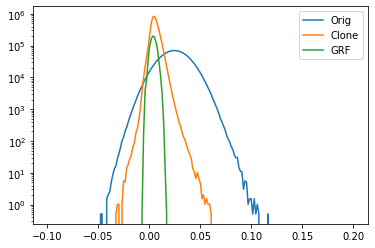

In [ ]:
#thresholds = np.linspace(-5, 5, 200)
thresholds = np.linspace(-0.1, 0.2 , 200)

t = (thresholds[1:]+thresholds[:-1])/2.0
plt.plot(t,orig_pc.mean(axis=0), label = 'Orig')
plt.plot(t,clone_pc.mean(axis=0), label = 'Clone')
plt.plot(t,grf_pc.mean(axis=0), label = 'GRF')

plt.legend(loc='best')
#plt.loglog();
plt.yscale('log')

In [ ]:
N = 200
all_orig_ps = np.zeros((N, 36**2, 179))
all_grf_ps = np.zeros((N, 36**2, 179))
all_clone_ps = np.zeros((N, 36**2, 179))

all_orig_pc = np.zeros((N, 36**2, 199))
all_grf_pc = np.zeros((N, 36**2, 199))
all_clone_pc = np.zeros((N, 36**2, 199))

all_orig_pdf = np.zeros((N, 36**2, 199))
all_grf_pdf = np.zeros((N, 36**2, 199))
all_clone_pdf = np.zeros((N, 36**2, 199))

all_ys = np.zeros((N, 2))
for boxno in range(N):
    print(boxno)
    boxname = 'Box%03d'%boxno
    with h5py.File(orig_fname, 'r') as f:
        y = f[boxname]['Y'][0,:]
        
    all_ys[boxno] = y.squeeze()
    #plot_pair(orig_fname, clone_fname, boxname, 128)
    
    orig_ps = compute_all_ps(orig_fname, boxname, mod=True)
    grf_ps = compute_all_ps(grf_fname, boxname)
    clone_ps = compute_all_ps(clone_fname, boxname)
    
    all_orig_ps[boxno] = orig_ps
    all_grf_ps[boxno] = grf_ps
    all_clone_ps[boxno] = clone_ps
    
    orig_pc = compute_all_pc(orig_fname, boxname, mod=True)
    grf_pc = compute_all_pc(grf_fname, boxname)
    clone_pc = compute_all_pc(clone_fname, boxname)
    
    all_orig_pc[boxno] = orig_pc
    all_grf_pc[boxno] = grf_pc
    all_clone_pc[boxno] = clone_pc
    
    orig_pdf = compute_all_pdf(orig_fname, boxname, mod=True)
    grf_pdf = compute_all_pdf(grf_fname, boxname)
    clone_pdf = compute_all_pdf(clone_fname, boxname)
    
    all_orig_pdf[boxno] = orig_pdf
    all_grf_pdf[boxno] = grf_pdf
    all_clone_pdf[boxno] = clone_pdf
    
    #fig = plt.figure(figsize = (12,6))
    #plt.subplot(121)
    #plt.plot(orig_ps.mean(axis=0), label = 'Orig')
    #plt.plot(clone_ps.mean(axis=0), label = 'Clone')
    #plt.legend(loc='best')
    #plt.loglog();
    #plt.subplot(122)
    #plt.plot(orig_pc.mean(axis=0), label = 'Orig')
    #plt.plot(clone_pc.mean(axis=0), label = 'Clone')
    #plt.legend(loc='best')
    #plt.loglog();
    
    #plt.show()

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60


In [ ]:
sorted_y_idxs = np.argsort(all_ys[:,0])
#sorted_y_idxs = np.argsort(all_ys[:,1])

In [ ]:
cmap = sns.cubehelix_palette(N, start=2, rot=0, dark=0.1, light=.95)

In [ ]:
fig = plt.figure(figsize = (9,6))

for idx, c in enumerate(cmap):
    i = sorted_y_idxs[idx]
    plt.subplot(311)
    plt.plot(all_orig_ps[i].mean(axis = 0), c = c, label = r'$\Omega_m=%0.2f$'%all_ys[i,0], alpha = 0.3)
    plt.subplot(312)
    plt.plot(all_grf_ps[i].mean(axis = 0), c = c, alpha = 0.3)
    plt.subplot(313)
    plt.plot(all_clone_ps[i].mean(axis = 0), c = c, alpha = 0.3)

#plt.legend(loc='best')
for i in range(3):
    plt.subplot(3,1,i+1)
    plt.loglog()
    #plt.xlim([-2,3]);
#plt.yscale('log');

In [ ]:
#nu_ = np.linspace(-5, 5, 200)
nu_ =  thresholds = np.arange(0.1, 0.3 ,0.001)

nu = (nu_[1:] + nu_[:-1])/2.0

In [ ]:
grf_pcs = np.zeros((289, 199))
grf_pdfs = np.zeros((289,199))
for i, im in enumerate(grfs):
    pc = image_pc(im)
    grf_pcs[i] = pc
    
    pdf = image_pdf(im)
    grf_pdfs[i] = pdf

In [ ]:
rand_images = np.random.randn(289, 256, 256)
rand_pcs = np.zeros((289, 199))
rand_pdfs = np.zeros((289,199))

for i, im in enumerate(rand_images):
    pc = image_pc(im)
    rand_pcs[i] = pc
    pdf = image_pdf(im)
    rand_pdfs[i] = pdf

In [ ]:
fig = plt.figure(figsize = (12,10))

for idx, c in enumerate(cmap):
    i = sorted_y_idxs[idx]
    plt.subplot(311)
    plt.title('Simulation Maps')
    plt.plot(nu, all_orig_pc[i].mean(axis = 0), c = c, label = r'$\Omega_m=%0.2f$'%all_ys[i,0], alpha = 0.7)
    plt.subplot(312)
    plt.title('GRF Maps')
    plt.plot(nu, all_grf_pc[i].mean(axis = 0), c = c, alpha = 0.7)
    plt.subplot(313)
    plt.title('Clone Maps')
    plt.plot(nu, all_clone_pc[i].mean(axis = 0), c = c, alpha = 0.7)
    
plt.legend(loc='best')
for i in xrange(3):
    plt.subplot(3,1,i+1)
    #plt.xlim([-5,5]);
    plt.yscale('log');

In [ ]:
fig = plt.figure(figsize = (12,6))
idx = 60
c = 'k'
i = sorted_y_idxs[idx]
#plt.subplot(311)
#plt.title('Simulation Maps')
plt.plot(nu, np.median(all_orig_pc[i], axis=0), c = c, alpha = 0.9)
#plt.subplot(312)
#plt.title('GRF Maps')
plt.plot(nu, np.median(all_grf_pc[i], axis=0), c = 'b', alpha = 0.9)
#plt.subplot(313)
#plt.title('Clone Maps')

plt.plot(nu, np.median(all_clone_pc[i], axis=0), c = 'r', alpha = 0.9)
    
plt.legend(loc='best')
#for i in xrange(3):
    #plt.subplot(3,1,i+1)
    #plt.xlim([-5,5]);
plt.yscale('log');

In [ ]:
fig = plt.figure(figsize = (8,6))

for idx, c in enumerate(cmap):
    i = sorted_y_idxs[idx]
    #plt.subplot(311)
    plt.title('Simulation Maps v Clone Maps')
    plt.plot(nu, all_orig_pc[i].mean(axis = 0), c = c, label = r'$\Omega_m=%0.2f$'%all_ys[i,0], alpha = 0.7)
    #plt.subplot(312)
    #plt.title('Clone Maps')
    plt.plot(nu, all_grf_pc[i].mean(axis=0), c=c, alpha = 0.7, ls = ':')
    plt.plot(nu, all_clone_pc[i].mean(axis = 0), c = c, alpha = 0.7, ls = '--')
    
#plt.subplot(313)
#plt.title('GRF')
#plt.plot(nu, grf_pcs.mean(axis = 0))

#plt.legend(loc='best')
#for i in xrange(3):
#    plt.subplot(3,1,i+1)
#plt.xlim([-5,5]);
plt.yscale('log');

In [ ]:
fig = plt.figure(figsize = (8,6))

#for idx, c in enumerate(cmap):
    #i = sorted_y_idxs[idx]
#plt.subplot(311)
plt.title('Peak Counts')
plt.plot(nu, all_orig_pc.mean(axis = (0,1)), label = 'Sims', alpha = 0.3, color = 'b')

plt.errorbar(nu, all_orig_pc.mean(axis = (0,1)), yerr = all_orig_pc.std(axis = (0,1)), alpha = 0.3, color = 'b')
#plt.subplot(312)
#plt.title('Clone Maps')
plt.plot(nu, all_clone_pc.mean(axis = (0,1)), label = 'Clones', alpha = 0.3, color = 'r')

plt.errorbar(nu, all_clone_pc.mean(axis = (0,1)),yerr = all_clone_pc.std(axis = (0,1)), alpha = 0.3, color = 'r')

plt.plot(nu, all_grf_pc.mean(axis = (0,1)), label = 'GRF', alpha = 0.3, color = 'g')

plt.errorbar(nu, all_grf_pc.mean(axis = (0,1)),yerr = all_grf_pc.std(axis = (0,1)), alpha = 0.3, color = 'g')

#plt.subplot(313)
#plt.title('GRF')
#plt.plot(nu, grf_pcs.mean(axis = 0), label = 'GRF')
#plt.plot(nu, rand_pcs.mean(axis = 0), label = 'Random')

plt.legend(loc='best')
#for i in xrange(3):
#    plt.subplot(3,1,i+1)
#plt.xlim([-6,6]);
plt.yscale('log');
plt.xlabel(r'Peak Height')

In [ ]:
fig = plt.figure(figsize = (8,6))

#for idx, c in enumerate(cmap):
    #i = sorted_y_idxs[idx]
#plt.subplot(311)
plt.title('Peak Counts')
plt.plot(nu, np.median(all_orig_pc, axis = (0,1)), label = 'Sims', alpha = 0.3, color = 'b')

plt.errorbar(nu, np.median(all_orig_pc,axis = (0,1)), yerr = all_orig_pc.std(axis = (0,1)), alpha = 0.3, color = 'b')
#plt.subplot(312)
#plt.title('Clone Maps')
plt.plot(nu, np.median(all_clone_pc,axis = (0,1)), label = 'Clones', alpha = 0.3, color = 'r')

plt.errorbar(nu, np.median(all_clone_pc, axis = (0,1)),yerr = all_clone_pc.std(axis = (0,1)), alpha = 0.3, color = 'r')

plt.plot(nu, np.median(all_grf_pc, axis = (0,1)), label = 'GRF', alpha = 0.3, color = 'g')

plt.errorbar(nu, np.median(all_grf_pc, axis = (0,1)),yerr = all_grf_pc.std(axis = (0,1)), alpha = 0.3, color = 'g')

#plt.subplot(313)
#plt.title('GRF')
#plt.plot(nu, grf_pcs.mean(axis = 0), label = 'GRF')
#plt.plot(nu, rand_pcs.mean(axis = 0), label = 'Random')

plt.legend(loc='best')
#for i in xrange(3):
#    plt.subplot(3,1,i+1)
#plt.xlim([-6,6]);
plt.yscale('log');
plt.xlabel(r'Peak Height')

K-s test of these 2 dists

In [ ]:
def ks_statistic(dist1, dist2):
    n,m = len(dist1), len(dist2)
    c = 1.358
    threshold = c*np.sqrt((n+m)*1.0/(n*m))
    d= np.max(np.abs(dist1-dist2))
    return d, d < threshold

In [ ]:
sim_pc = all_orig_pc.mean(axis = (0,1))
clone_pc = all_clone_pc.mean(axis = (0,1))

In [ ]:
sim_max_idx, clone_max_idx= np.argmax(sim_pc), np.argmax(clone_pc) 

In [ ]:
print np.abs(sim_max_idx- clone_max_idx)

In [ ]:
sim_max, clone_max = sim_pc[sim_max_idx], clone_pc[clone_max_idx]

In [ ]:
grf_pc = grf_pcs.mean(axis=0)
grf_pc/=np.max(grf_pc)
print np.abs(np.argmax(grf_pc) - sim_max_idx)

In [ ]:
rand_pc = rand_pcs.mean(axis=0)
rand_pc/=np.max(rand_pc)
print np.abs(np.argmax(rand_pc) - sim_max_idx)

In [ ]:
np.argmax(rand_pc[20:])

In [ ]:
len(rand_pc[20:-9]),len(nu[12:-17])

In [ ]:
ks_statistic(sim_pc/sim_max, clone_pc/clone_max)

In [ ]:
fig = plt.figure(figsize = (8,6))

#for idx, c in enumerate(cmap):
    #i = sorted_y_idxs[idx]
#plt.subplot(311)
plt.title('PDFs')
plt.plot(nu, all_orig_pdf.mean(axis = (0,1)), label = 'Sims')
#plt.subplot(312)
#plt.title('Clone Maps')
plt.plot(nu, all_grf_pdf.mean(axis = (0,1)), label = 'GRF')

plt.plot(nu, all_clone_pdf.mean(axis = (0,1)), label = 'Clones')

#plt.subplot(313)
#plt.title('GRF')
#plt.plot(nu, grf_pdfs.mean(axis = 0), label = 'GRF', alpha = 0.4)
#plt.plot(nu, rand_pdfs.mean(axis = 0), label = 'Random', alpha = 0.4)

plt.legend(loc='best')
#for i in xrange(3):
#    plt.subplot(3,1,i+1)
#plt.xlim([-6,6]);
#plt.yscale('log');

In [ ]:
ks_statistic(all_orig_pdf.mean(axis = (0,1)), all_clone_pdf.mean(axis=(0,1)))

In [ ]:
from scipy.stats import skewtest, skew

In [ ]:
skew(all_orig_pdf.mean(axis = (0,1)))

In [ ]:
skew(all_grf_pdf.mean(axis = (0,1)))

In [ ]:
skew(all_clone_pdf.mean(axis = (0,1)))

In [ ]:
skew(grf_pdfs.mean(axis=0))

In [ ]:
skew(rand_pdfs.mean(axis=0))

idea: cross correlate peak locations with embedding maps 